# are lncRNAs quantified?

compare read counts to reads in a nearby "null" section of genome to see.

1. aggregate nulls and reads for each tissue
2. get yes/no for each gene if it is quantified in each tissue
3. plot patterns of quantification across tissues

In [1]:
import seaborn as sns
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import os
from scipy import stats
import numpy as np
from matplotlib.colors import LogNorm
import pyranges as pr
import upsetplot as up

%config InlineBackend.figure_formats = ['png']
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7})

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
rnaseqc_dir = '/home/klawren/oak/gtex/output/all_tissues/'
null_dir = '/home/klawren/oak/gtex/output/all_tissues_null/v11_intergenic/'

bring in the gtex colors and make a palette

In [3]:
# Load JSON data from a file
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json', 'r') as file:
    tissue_color_data = json.load(file)

# Convert the JSON data to a DataFrame
tissue_color_df = pd.DataFrame.from_dict(tissue_color_data, orient='index')
tissue_color_df.index.set_names('tissue_name', inplace=True)
tissue_color_df.reset_index(inplace=True)
tissue_color_df['tissue_color_hex'] = '#' + tissue_color_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_color_df['tissue_color_hex'])

gene_type_pal_highlight = {'new_lncRNA':'#fb83ba',
                            'other_lncRNA':'#b70657',
                            'protein_coding':'#215B30',
                            'other_noncoding_RNA':'#6A5ACD',
                            'pseudogene':'#005BBF', 
                            'artifact':'grey'}
gene_type_order_highlight = ['new_lncRNA', 'other_lncRNA', 'protein_coding', 'pseudogene', 'other_noncoding_RNA']


In [4]:
# bring in gencode ids
gencode_ids = pd.read_csv('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_simplified.txt', sep='\t', index_col=0)
gencode_ids['gene_type_grouped_highlight'] = np.where(gencode_ids['gene_type_grouped_highlight'] == 'CLS_lncRNA', 'new_lncRNA', gencode_ids['gene_type_grouped_highlight'])

which samples belong to which tissues and pass qc?

from francois: "use the SMAFRZE column (== ‘RNASEQ’)"

I only consider tissues with more than 30 samples

In [5]:
# load in tissue-sample matching
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE']=='RNASEQ']
tissue_sample_lists = passed_samples.groupby('SMTSD').agg({'SAMPID':'unique'})

/local/scratch/klawren/slrmtmp.48491945/ipykernel_4738/682259141.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


In [6]:
# only consider tissues with more than this number of samples
tissue_cutoff = 30

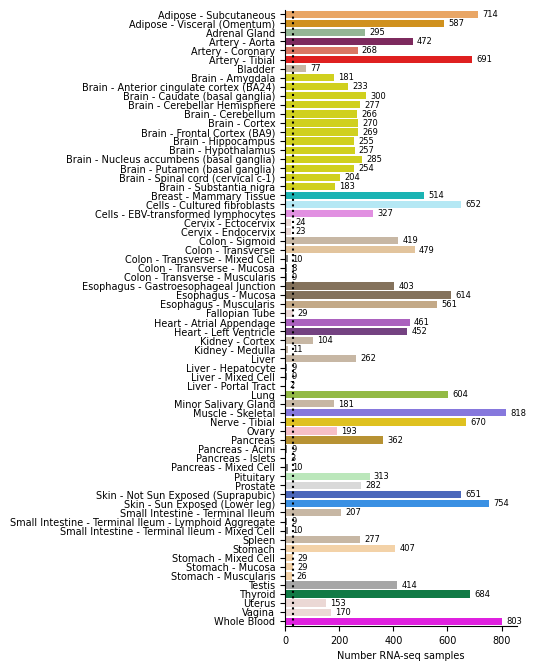

In [7]:
num_samples = pd.DataFrame(passed_samples.groupby('SMTSD').size()).rename(columns={0:'num_samples'})
num_samples = pd.merge(num_samples.reset_index(), tissue_color_df, right_on='tissue_name', left_on='SMTSD', how='left')
num_samples['tissue_color_hex'] = num_samples['tissue_color_hex'].fillna('#808080')


# plot the number of samples in each tissue
fig, ax = plt.subplots(figsize=(3,8))

sns.barplot(ax=ax,
              data=num_samples, 
              x='num_samples',
              hue='SMTSD',
              y='SMTSD',
              palette=sns.color_palette(num_samples['tissue_color_hex']),
              order=num_samples['SMTSD'],
              legend=False)

for container in ax.containers:
    ax.bar_label(container, fontsize=6, padding=3)

ax.set_xlabel('Number RNA-seq samples')
ax.set_ylabel('')
ax.axvline(tissue_cutoff, color='k', ls=':')

ax.spines[['top', 'right']].set_visible(False)
plt.show()


For each tissue, aggregate the samples gene counts for the actual genes and the matched null

In [8]:
# aggregate sample level counts to a df
def agg_rnaseqc(output_dir, tissue_sample_ids, file_end='gene_reads'):
    sample_tpms = []
    # get tpms for all samples 
    for sample_id in tqdm(tissue_sample_ids):
        expected_filename = f"{sample_id}.{file_end}.gct.gz"
        file_path = os.path.join(os.path.join(output_dir, 'rnaseq_qc'), expected_filename)
        if os.path.isfile(file_path):
            sample_tpms.append(pd.read_csv(file_path, sep='\t', skiprows=2).set_index(['Name', 'Description']))
        else:
            print(f"File not found: {file_path}")
    tpm_agg = pd.concat(sample_tpms, axis=1).reset_index()
    return tpm_agg


# get null and gene aggreagations (read in if exisitng otherwise create)
def get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id, file_end='gene_reads'):
    print('Processing samples for {}'.format(tissue_id))
    sample_ids = tissue_sample_lists.loc[tissue_id]['SAMPID']
    tissue_id_clean = tissue_id.replace(' - ', '_').replace('-', '_').replace(' ', '_').replace('(', '').replace(')', '')

    gene_agg_path = os.path.join(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), f"{tissue_id_clean}.v11.{file_end}.gct.gz")
    print(f'\t{gene_agg_path}')
    try:
        gene_agg = pd.read_csv(gene_agg_path, sep='\t')
    except FileNotFoundError:
        gene_agg = agg_rnaseqc(rnaseqc_dir, sample_ids, file_end=file_end)
        os.makedirs(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), exist_ok=True)
        gene_agg.to_csv(gene_agg_path, sep='\t', index=False, compression='gzip')

    null_agg_path = os.path.join(os.path.join(null_dir, 'rnaseqc_agg') ,f"{tissue_id_clean}.v11_null.{file_end}.gct.gz")
    print(f'\t{null_agg_path}')
    try:
        null_agg = pd.read_csv(null_agg_path, sep='\t')
    except FileNotFoundError:
        null_agg = agg_rnaseqc(null_dir, sample_ids, file_end=file_end)
        os.makedirs(os.path.join(null_dir, 'rnaseqc_agg'), exist_ok=True)
        null_agg.to_csv(null_agg_path, sep='\t', index=False, compression='gzip')

    # null for mitochondial genes doesn't work, becuase there isn't enough null space on the mitochondiral genome
    print('\tRemoving {} mito genes that dont have matched null'.format(len(gene_agg[~gene_agg['Name'].isin(null_agg['Name'])])))
    gene_agg = gene_agg[gene_agg['Name'].isin(null_agg['Name'])]
    return gene_agg, null_agg

Processing samples for Testis
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Testis.v11.gene_reads.gct.gz
	/home/klawren/oak/gtex/output/all_tissues_null/v11_intergenic/rnaseqc_agg/Testis.v11_null.gene_reads.gct.gz
	Removing 38 mito genes that dont have matched null


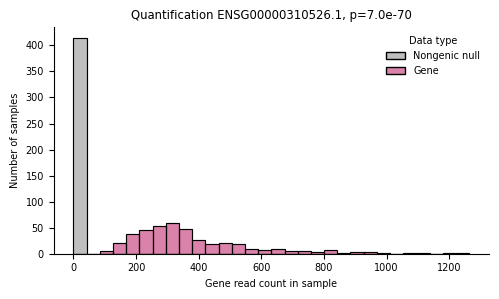

In [9]:
def plot_matched_null(sample_gene_id, gene_agg, null_agg):
    sample_columns = gene_agg.columns[2:]
    null_counts  = null_agg[null_agg['Name']==sample_gene_id][sample_columns].values[0]
    gene_counts  = gene_agg[gene_agg['Name']==sample_gene_id][sample_columns].values[0]
    stat, p_value = stats.wilcoxon(gene_counts, null_counts, alternative='greater')
    # plot the two distributions for a sample gene
    plot_df = pd.DataFrame({
        'count': np.concatenate([null_counts, gene_counts]),
        'distribution': ['Nongenic null'] * len(null_counts) + ['Gene'] * len(gene_counts)})

    fig, ax = plt.subplots(figsize=(5,3))
    if max(gene_counts) > 30:
        sns.histplot(plot_df,x='count', bins=30, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    else:
        sns.histplot(plot_df,x='count', discrete=True, hue='distribution', ax=ax, palette=['grey', '#b70657'])
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Gene read count in sample')
    ax.set_ylabel('Number of samples')
    # Customize the legend
    legend = ax.get_legend()
    legend.get_frame().set_visible(False)
    legend.set_title("Data type")
    ax.set_title('Quantification {}, p={:.1e}'.format(sample_gene_id, p_value))
    fig.tight_layout()

gene_agg, null_agg = get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, 'Testis')
plot_matched_null(gene_agg['Name'].iloc[1], gene_agg, null_agg)

In [10]:
# get p values for the tissue
def get_tissue_pvalues(gene_agg, null_agg):
    print('\tCalculating p values...')

    sample_columns = gene_agg.columns[2:]
    null_counts_array = null_agg.set_index('Name').loc[gene_agg['Name']][sample_columns].values
    gene_counts_array = gene_agg.set_index('Name').loc[gene_agg['Name']][sample_columns].values

    p_values = np.empty(len(gene_agg['Name']))
    median_counts = np.empty(len(gene_agg['Name']))
    mean_counts = np.empty(len(gene_agg['Name']))
    median_null_counts = np.empty(len(gene_agg['Name']))
    mean_null_counts = np.empty(len(gene_agg['Name']))

    for idx in tqdm(range(len(gene_agg['Name'])), total=len(gene_agg['Name'])):
        null_counts = null_counts_array[idx]
        gene_counts = gene_counts_array[idx]
        if np.all(gene_counts == 0) or np.all(gene_counts == null_counts):
            # if all are the zero
            p_value = 1
        else:
            stat, p_value = stats.wilcoxon(gene_counts, null_counts, alternative='greater')
            
        p_values[idx] = p_value
        median_counts[idx] = np.median(gene_counts)
        mean_counts[idx] = np.mean(gene_counts)
        median_null_counts[idx] = np.median(null_counts)
        mean_null_counts[idx] = np.mean(null_counts)
    return p_values, median_counts, mean_counts, median_null_counts, mean_null_counts

def get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id):

    tissue_id_clean = tissue_id.replace(' - ', '_').replace('-', '_').replace(' ', '_').replace('(', '').replace(')', '')
    quantifications_path = os.path.join(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), f"{tissue_id_clean}.v11.null_quantifications.txt")
    print(f'\t{quantifications_path}')

    try:
        quantifications = pd.read_csv(quantifications_path, sep='\t')
        num_considered = (quantifications[f'{tissue_id}.mean_counts'] > 0).sum()
        quantifications[f'{tissue_id}.quantified_corrected'] = quantifications[f'{tissue_id}.null_p'] < (.05/num_considered)
        
    except FileNotFoundError:
        os.makedirs(os.path.join(rnaseqc_dir, 'rnaseqc_agg'), exist_ok=True)

        gene_agg, null_agg = get_aggregation_pair_tissue(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id)
        p_values, median_counts, mean_counts, median_null_counts, mean_null_counts = get_tissue_pvalues(gene_agg, null_agg)

        quantifications = pd.DataFrame({'Name':gene_agg['Name']})
        quantifications[f'{tissue_id}.null_p'] = p_values
        quantifications[f'{tissue_id}.median_counts'] = median_counts
        quantifications[f'{tissue_id}.mean_counts'] = mean_counts
        quantifications[f'{tissue_id}.median_null_counts'] = median_null_counts
        quantifications[f'{tissue_id}.mean_null_counts'] = mean_null_counts
        quantifications[f'{tissue_id}.quantified'] = quantifications[f'{tissue_id}.null_p'] < (.05/len(quantifications))
        num_considered = (quantifications[f'{tissue_id}.mean_counts'] > 0).sum()
        quantifications[f'{tissue_id}.quantified_corrected'] = quantifications[f'{tissue_id}.null_p'] < (.05/num_considered)
        quantifications.to_csv(quantifications_path, sep='\t', index=False)

    return quantifications

look at one of the lower sample size ones - fallopian tube. I think that the sample size is too low here. looks like lots of false negatives - this would indicate to me that we need to limit to tissues with > 30 samples, or do a looser p value cutoff

In [11]:
tissue_id = 'Testis'

test_quantifications = get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id)

	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Testis.v11.null_quantifications.txt


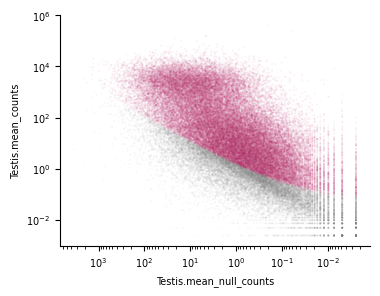

In [12]:
fig, ax = plt.subplots(figsize=(4,3))

sns.scatterplot(test_quantifications, ax=ax, x=f'{tissue_id}.mean_null_counts', y=f'{tissue_id}.mean_counts', hue=f'{tissue_id}.quantified_corrected', alpha=.05, s=2, legend=False, palette=['grey', '#b70657'])
ax.set_xscale('log')
ax.invert_xaxis()
ax.set_yscale('log')
ax.spines[['top', 'right']].set_visible(False)
plt.show()

Scale up and look across tissues

In [13]:
# only consider those with more that 20 samples

print(passed_samples.groupby('SMTSD').size()[passed_samples.groupby('SMTSD').size() < tissue_cutoff]) 
large_sample_size_tissues = passed_samples.groupby('SMTSD').size()[passed_samples.groupby('SMTSD').size() > tissue_cutoff].index
print('continuing with {} tissues'.format(len(large_sample_size_tissues)))

tissue_sample_lists = tissue_sample_lists[tissue_sample_lists.index.isin(large_sample_size_tissues)]
passed_samples = passed_samples[passed_samples['SMTSD'].isin(large_sample_size_tissues)]
tissue_color_df = tissue_color_df[tissue_color_df['tissue_name'].isin(large_sample_size_tissues)]
tissue_color_palette = sns.color_palette(tissue_color_df['tissue_color_hex'])

SMTSD
Cervix - Ectocervix                                      24
Cervix - Endocervix                                      23
Colon - Transverse - Mixed Cell                          10
Colon - Transverse - Mucosa                               8
Colon - Transverse - Muscularis                           9
Fallopian Tube                                           29
Kidney - Medulla                                         11
Liver - Hepatocyte                                        9
Liver - Mixed Cell                                        9
Liver - Portal Tract                                      2
Pancreas - Acini                                          9
Pancreas - Islets                                         3
Pancreas - Mixed Cell                                    10
Small Intestine - Terminal Ileum - Lymphoid Aggregate     9
Small Intestine - Terminal Ileum - Mixed Cell            10
Stomach - Mixed Cell                                     29
Stomach - Mucosa                  

In [14]:
quantifications = get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_sample_lists.index.values[0])
for tissue_id in tissue_sample_lists.index.values[1:]:
    quantifications = pd.merge(quantifications, get_null_quantifications(rnaseqc_dir, null_dir, tissue_sample_lists, tissue_id), on='Name')

# add in gene type information
quantifications = pd.merge(quantifications, gencode_ids, left_on='Name', right_on='gene_id_v47')

	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Adipose_Subcutaneous.v11.null_quantifications.txt


	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Adipose_Visceral_Omentum.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Adrenal_Gland.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Artery_Aorta.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Artery_Coronary.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Artery_Tibial.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Bladder.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Amygdala.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Anterior_cingulate_cortex_BA24.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Caudate_basal_ganglia.v11.null_quantifications.txt
	/home/klawren/oak/gtex/output/all_tissues/rnaseqc_agg/Brain_Cerebellar_He

null counts sanity check 

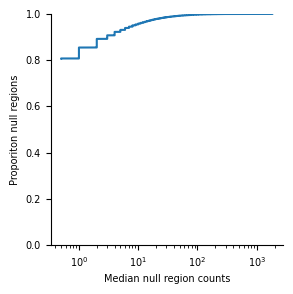

In [18]:
# null counts
null_counts_columns = [f'{tissue_id}.median_null_counts' for tissue_id in tissue_sample_lists.index.values]

null_counts = quantifications[null_counts_columns[:-5]].median(axis=1)
fig, ax = plt.subplots(figsize=(3,3))


sns.ecdfplot(ax=ax,
              data=null_counts, 
              log_scale=True)

ax.set_xlabel('Median null region counts')
ax.set_ylabel('Proporiton null regions')
ax.spines[['top', 'right']].set_visible(False)


proportion that are expressed

In [20]:
# proportion of group expressed in each tissue category
quantification_columns = [f'{tissue_id}.quantified_corrected' for tissue_id in tissue_sample_lists.index.values]


proportion_expressed = quantifications.groupby('gene_type_grouped_highlight').agg({tissue: 'mean' for tissue in quantification_columns})
proportion_expressed = proportion_expressed.reset_index().melt(id_vars='gene_type_grouped_highlight', value_vars=quantification_columns, value_name='proportion_expressed')
proportion_expressed['tissue'] = proportion_expressed['variable'].str.split('.quantified').str[0]

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/local/scratch/klawren/slrmtmp.48491945/ipykernel_4738/3627775039.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['new lncRNA', 'existing lncRNA', 'other ncRNA', 'protein coding', 'pseudogene'])
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 18.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


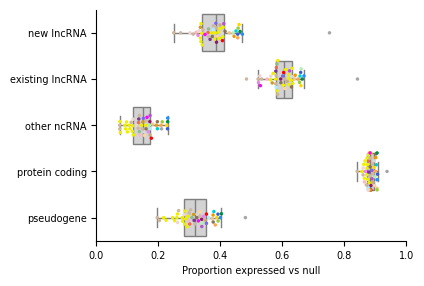

In [21]:
fig, ax = plt.subplots(figsize=(4,3))

sns.swarmplot(proportion_expressed[proportion_expressed['gene_type_grouped_highlight']!='artifact'], ax=ax, hue='tissue', y='gene_type_grouped_highlight', x='proportion_expressed',  palette=tissue_color_palette, hue_order=tissue_color_df['tissue_name'], legend=False, zorder=2, s=2.5)

sns.boxplot(proportion_expressed[proportion_expressed['gene_type_grouped_highlight']!='artifact'], x='proportion_expressed', y='gene_type_grouped_highlight', legend=None, fill=True, fliersize=0, ax=ax, color='lightgrey', zorder=1)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Proportion expressed vs null')
ax.set_ylabel('')
ax.set_xlim([0,1])

ax.set_yticklabels(['new lncRNA', 'existing lncRNA', 'other ncRNA', 'protein coding', 'pseudogene'])
plt.show()

tissue sharing vs sepcificity

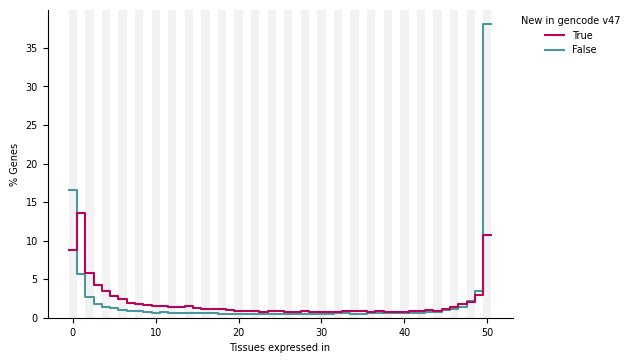

85.3% are quantified in at least one tissue
	91.2% new in v47 are quantified in at least one tissue
	79.7% are quantified in at least one tissue excluding testis


In [22]:
quantifications['new_to_v47'] = quantifications['Name'].isin(gencode_ids[~gencode_ids['in_v39_full']]['gene_id_v47'])
quantifications['num_quantified'] = quantifications[quantification_columns].sum(axis=1)

fig, ax = plt.subplots(figsize=(6,4))

sns.histplot(ax=ax,
              data=quantifications, 
              x='num_quantified', 
              hue='new_to_v47',
              palette=['#b70657', '#4a989c'],
              hue_order=[True, False], 
              discrete=True,
              element='step', 
              fill=False, 
              stat='percent', 
              common_norm=False)

ax.set_ylabel('% Genes')
ax.set_xlabel('Tissues expressed in')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.01), frameon=False, title='New in gencode v47')
ax.spines[['top', 'right']].set_visible(False)
for i in range(0, len(large_sample_size_tissues)+1, 2):  
    ax.axvspan(i-.5, i+.5, color='grey', alpha=0.1, lw=0)  

plt.show()

print('{:.1f}% are quantified in at least one tissue'.format((quantifications['num_quantified'] != 0).mean()*100))
print('\t{:.1f}% new in v47 are quantified in at least one tissue'.format((quantifications[quantifications['new_to_v47']]['num_quantified'] != 0).mean()*100))
quantifications['num_quantified_non_testis'] = quantifications[[*quantification_columns[:-5] , *quantification_columns[-4:]]].sum(axis=1)
print('\t{:.1f}% are quantified in at least one tissue excluding testis'.format((quantifications['num_quantified_non_testis'] != 0).mean()*100))


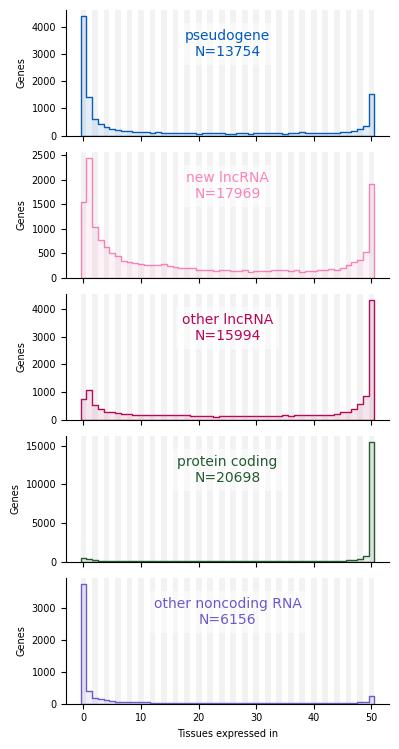

In [23]:
gene_types = quantifications['gene_type_grouped_highlight'].unique()
gene_types = gene_types[gene_types!='artifact']

fig, axes = plt.subplots(nrows=len(gene_types), ncols=1, figsize=(4, 1.5 * len(gene_types)), sharex=True)

# Create a histogram for each gene type in separate subplots
for ax, gene_type in zip(axes, gene_types):
    sub_group = quantifications[quantifications['gene_type_grouped_highlight'] == gene_type]
    sns.histplot(ax=ax,
                 data=sub_group, 
                 x='num_quantified', 
                 color=gene_type_pal_highlight[gene_type],
                 discrete=True,
                 element='step', 
                 stat='count', 
                 common_norm=False, 
                 alpha=.1)
    ax.text(0.5, 0.85, '{}\nN={}'.format(gene_type.replace('_', ' '), len(sub_group)), transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'), color=gene_type_pal_highlight[gene_type])



    ax.set_ylabel('Genes')
    ax.spines[['top', 'right']].set_visible(False)
    for i in range(0, len(large_sample_size_tissues)+1, 2):  
        ax.axvspan(i-.5, i+.5, color='grey', alpha=0.1, lw=0)  

axes[-1].set_xlabel('Tissues expressed in')

plt.tight_layout()
plt.show()


look at patterns of tissue sharing

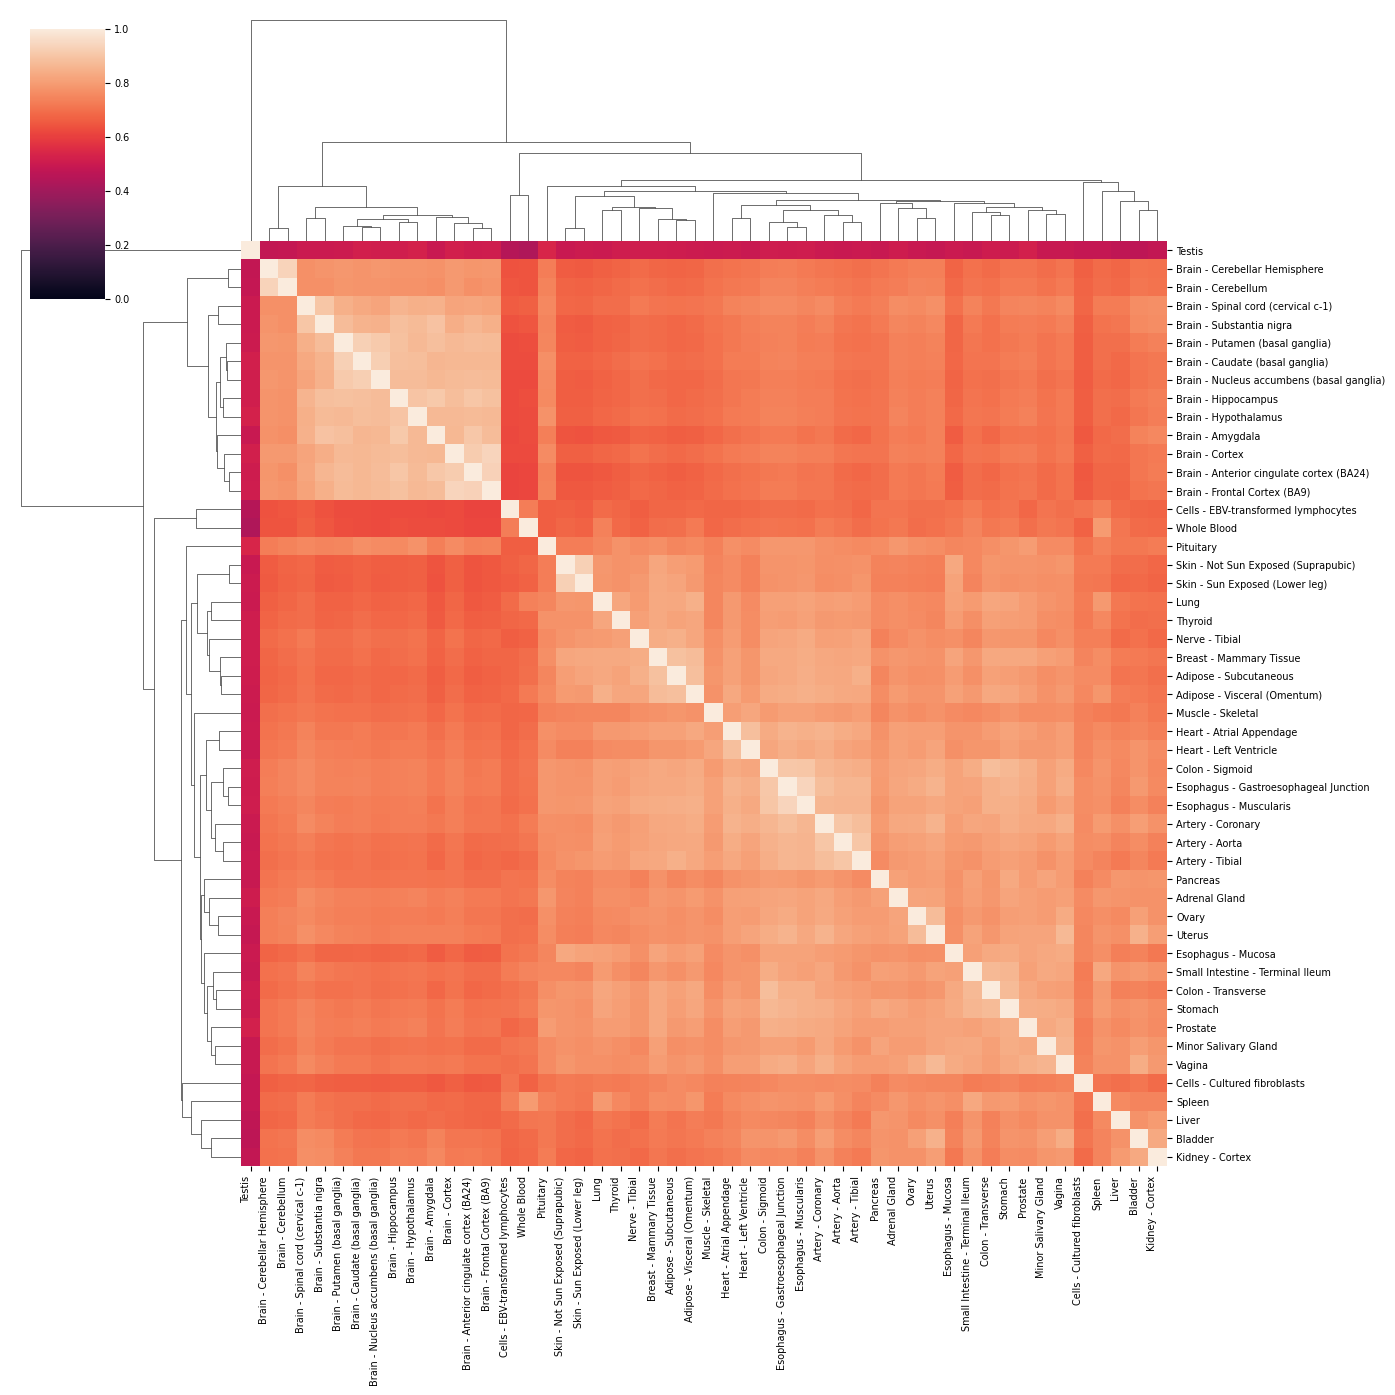

In [ ]:
# heatmap for quantification, using all genes
quantification_df = quantifications.set_index('Name')[quantification_columns]
g = sns.clustermap(quantification_df.corr(method='spearman').fillna(0), 
               figsize=(15, 15), 
               vmin=0, 
               vmax=1)

new_labels_x = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_xticklabels()]
g.ax_heatmap.set_xticklabels(new_labels_x, rotation=90, ha='right')
new_labels_y = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_yticklabels()]
g.ax_heatmap.set_yticklabels(new_labels_y, rotation=0)

plt.show()

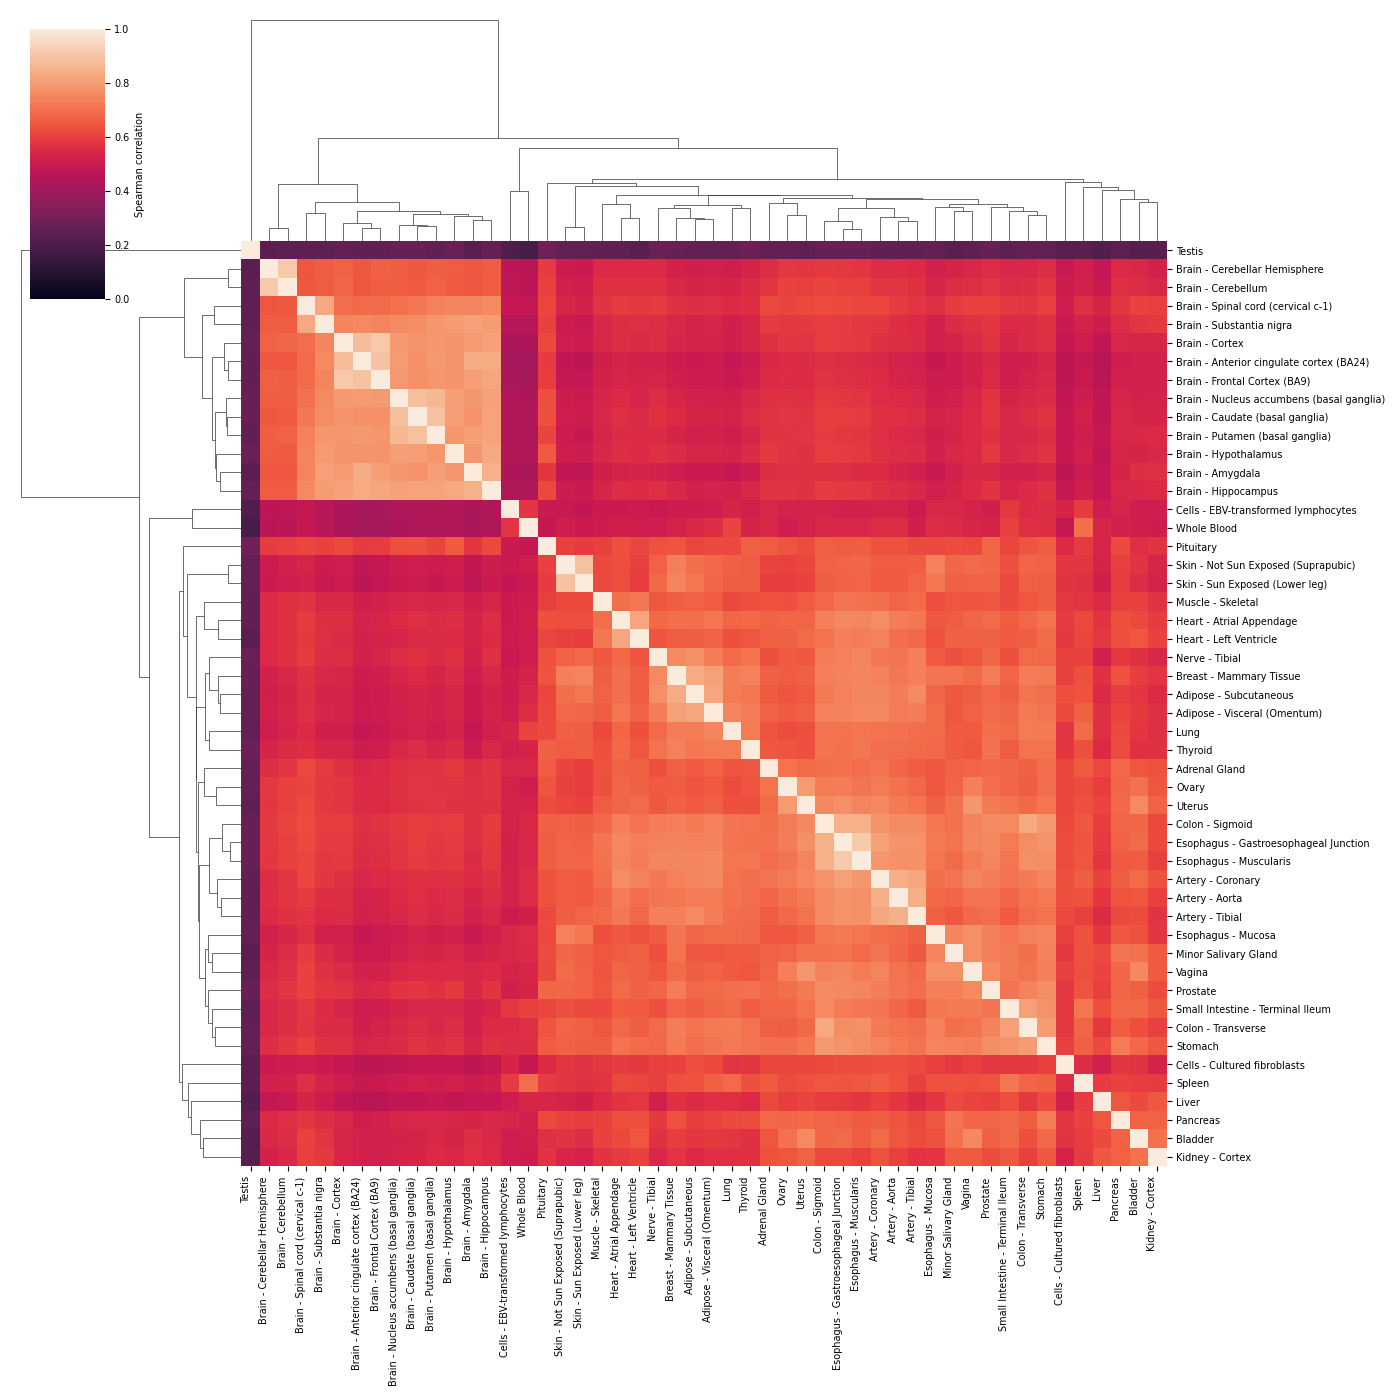

In [42]:
# heatmap for quantification, using just new lncRNAs
quantification_df = quantifications[quantifications['gene_type_grouped_highlight'] =='new_lncRNA'].set_index('Name')[quantification_columns]
g = sns.clustermap(quantification_df.corr(method='spearman').fillna(0), 
               figsize=(15, 15), 
               vmin=0, 
               vmax=1, 
               cbar_kws={'label': 'Spearman correlation'}, 
               cmap='rocket')

new_labels_x = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_xticklabels()]
g.ax_heatmap.set_xticklabels(new_labels_x, rotation=90, ha='right')
new_labels_y = [label.get_text().replace('.quantified_corrected', '') for label in g.ax_heatmap.get_yticklabels()]
g.ax_heatmap.set_yticklabels(new_labels_y, rotation=0)

plt.show()

now look at larger "tissue groups"

In [28]:
tissue_groups = sample_meta[sample_meta['SMTSD'].isin(large_sample_size_tissues)].groupby('SMTS').agg({'SMTSD':'unique'})
for tissue_group, tissue_names in tissue_groups.iterrows():
    quantifications[f'{tissue_group}.group.quantified'] = quantifications[[f'{t}.quantified' for t in tissue_names['SMTSD']]].sum(axis=1) > 0

tissue_group_columns = [f'{t}.group.quantified' for t in tissue_groups.index]

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


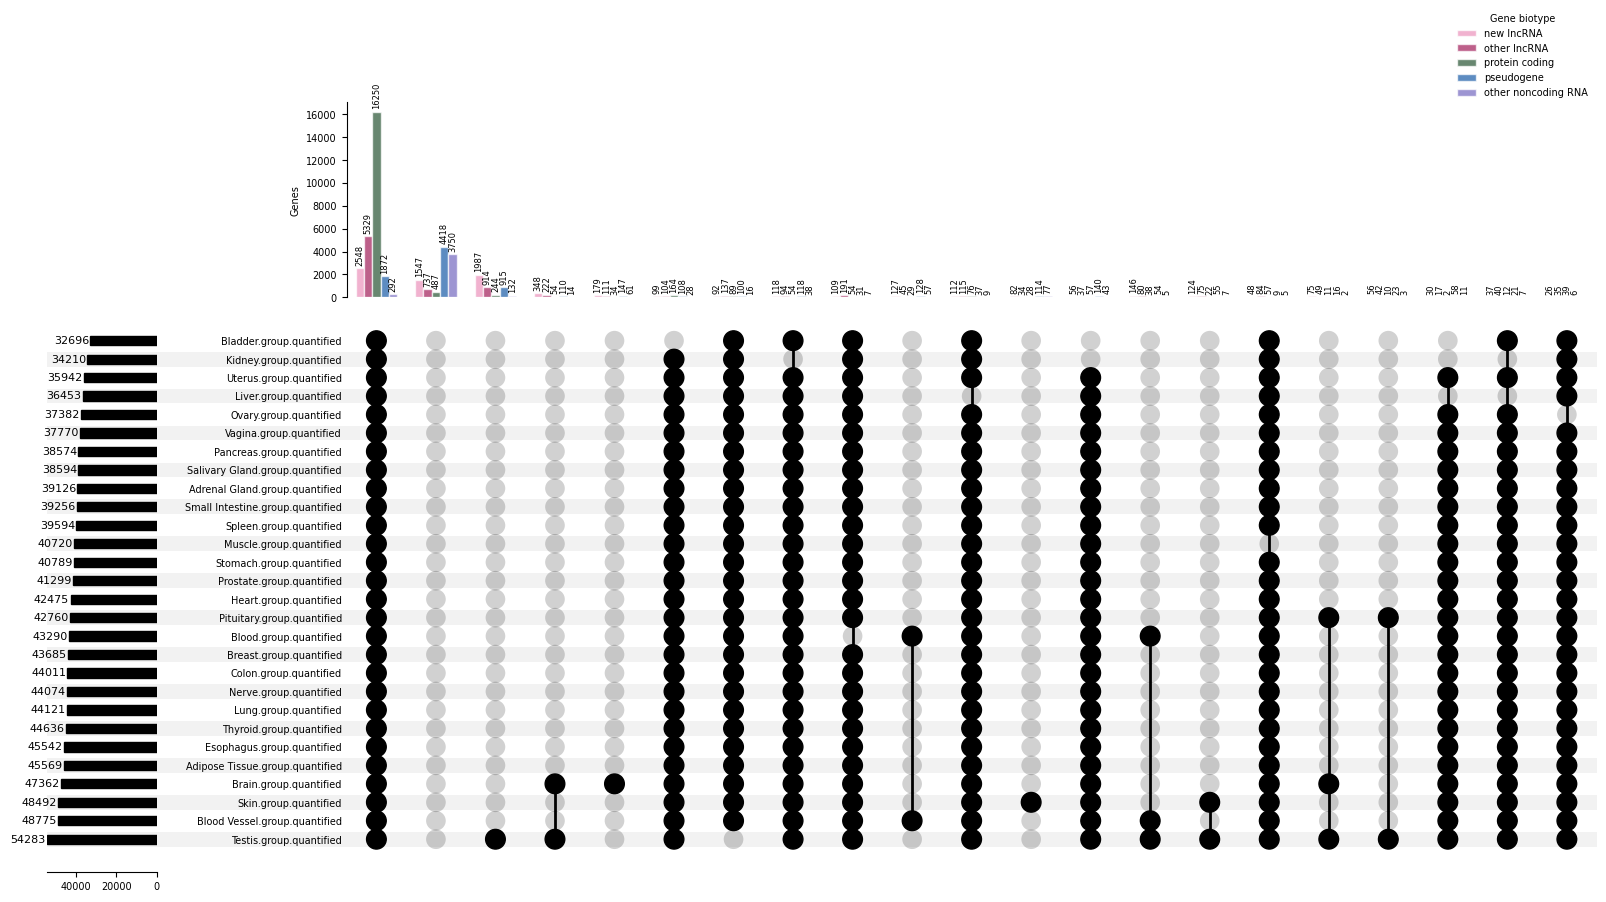

In [29]:
tissue_group_upset = up.from_indicators(quantifications[tissue_group_columns], data=quantifications['gene_type_grouped_highlight'])
min_size = 100
tissue_group_upset = pd.DataFrame(tissue_group_upset)
upset_categories =tissue_group_upset.index.value_counts()[tissue_group_upset.index.value_counts() > min_size].index
category_to_idx = {category: idx for idx, category in enumerate(upset_categories)}
tissue_group_upset['idx_loc'] = tissue_group_upset.index.map(category_to_idx)

fig = plt.figure(figsize=(20, 10))
upset = up.UpSet(tissue_group_upset, show_counts=False, subset_size='count', intersection_plot_elements=10, totals_plot_elements=2, element_size=None, sort_by='cardinality', min_subset_size=min_size)
plot_result = upset.plot(fig=fig, )

print(plot_result.keys())

totals_ax = plot_result['totals']
totals_ax.grid(False)
# add numbers to plot
for container in totals_ax.containers:
    totals_ax.bar_label(container, padding=1, fontsize=8,)

bar_ax = plot_result['intersections']
bar_ax.clear()
sns.countplot(tissue_group_upset.reset_index(), x='idx_loc', hue='gene_type_grouped_highlight',ax=bar_ax, palette=gene_type_pal_highlight, hue_order=gene_type_order_highlight, alpha=.7, edgecolor='white', width=.7)
bar_ax.set_ylabel('Genes')
#bar_ax.set_yscale('log')

# add numbers to plot
for container in bar_ax.containers:
    bar_ax.bar_label(container, padding=2, fontsize=6, rotation=90)

sns.move_legend(bar_ax, "upper right", bbox_to_anchor=(1, 1.5), frameon=False, title='Gene biotype')
legend = bar_ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

/local/scratch/klawren/slrmtmp.48491945/ipykernel_4738/615949657.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_testis_unique['Testis.group.quantified'] = 0


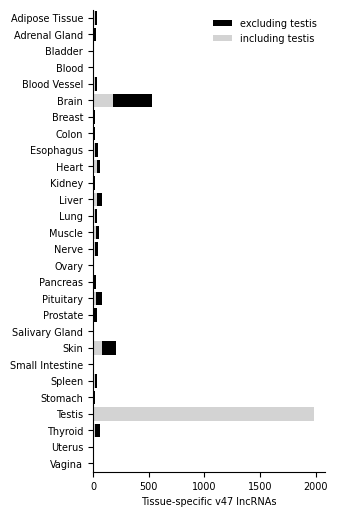

In [31]:
# only expressed in 1 tisssue
unique_genes = quantifications[quantifications[tissue_group_columns].sum(axis=1)==1]

# only expresssed in one tissue (excluding testis)
non_testis_tissue_groups = [t for t in tissue_group_columns if t not in ['Testis.group.quantified'] ]
non_testis_unique = quantifications[quantifications[non_testis_tissue_groups].sum(axis=1)==1]
non_testis_unique['Testis.group.quantified'] = 0

unique_genes = pd.DataFrame(unique_genes[unique_genes['gene_type_grouped_highlight']=='new_lncRNA'][tissue_group_columns].sum(axis=0)).rename(columns={0:'unique'})
non_testis_unique = pd.DataFrame(non_testis_unique[non_testis_unique['gene_type_grouped_highlight']=='new_lncRNA'][tissue_group_columns].sum(axis=0)).rename(columns={0:'non_testis_unique'})


unique_gene_counts = pd.merge(non_testis_unique.reset_index(), unique_genes.reset_index(), on='index')
unique_gene_counts['tissue_group'] = unique_gene_counts['index'].str.split('.group').str[0]
unique_gene_counts = unique_gene_counts.melt(id_vars='tissue_group', value_name='genes', value_vars=['non_testis_unique', 'unique'])

fig, ax = plt.subplots(figsize=(3,6))
sns.barplot(unique_gene_counts, ax=ax, y='tissue_group', hue='variable', x='genes', dodge=False, palette=['black', 'lightgrey'])

ax.set_xlabel('Tissue-specific v47 lncRNAs')
ax.set_ylabel('')
ax.spines[['top', 'right']].set_visible(False)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, title='', labels=['excluding testis', 'including testis'])

